In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [112]:
import pdb

In [31]:
plt.rcParams.update({'font.size':16})

# load a bird, get its songs from some day

In [3]:
from data.dataset import bird_dataset_single_hdf

In [4]:
dataset = bird_dataset_single_hdf('/home/songbird/datapartition/all_birds.hdf', 'r15y5')

... total number of folders for bird r15y5 = 41 ...


In [5]:
# choose a day
X = dataset.get(day=18, nsamps=-1)

In [7]:
len(X)

2906

# Compare the mean squared error performance of the learned PCA model and the autoencoder

In [39]:
from utils.utils import load_netG, load_netE, overlap_encode, overlap_decode
from reconstruction_error.pca import reconstruction, split_song_sequence, pca_decode, pca_encode

### Load networks and reconstruct

In [9]:
netG = load_netG('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz16_alldaysnets_ngf64/netG_epoch_60_day_all.pth', nz=16, ngf=64,
                 cuda=True, resnet=True)

In [10]:
netE = load_netE('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz16_alldaysnets_ngf64/netE_epoch_60_day_all.pth', nz=16, ngf=64,
                 cuda=True, resnet=True)

In [60]:
# encode
Z = [overlap_encode(x, netE) for x in X]
# decode
Xhat = [overlap_decode(z, netG)[0] for z in Z]

In [61]:
len(Xhat)

2906

## learn a new pca model

In [89]:
from reconstruction_error.pca import learn_pca_model

In [159]:
mu = np.mean(Xorig, axis=0)
mu = np.tile(mu, (Xorig.shape[0], 1))
mu.shape

(61557, 2064)

In [133]:
pca_model = PCA(n_components = 0.98, random_state = 100)
pca_model.fit(Xorig)

PCA(n_components=0.98, random_state=100)

In [134]:
pca_model.n_components_

834

### or load a pre-trained pca model

In [13]:
from sklearn.decomposition import PCA

In [14]:
pca_model = joblib.load('/home/songbird/datapartition/mdgan_output/daily_gan/r15y5_nz16_alldaysnets_ngf64/pca_model.pkl')

In [15]:
pca_model = pca_model['pca_model']

## Reconstruct with PCA

In [135]:
Xhat_pca, _ = reconstruction(X, pca_model)

.... done with 0.0 percent ....
.... done with 0.017205781142463867 percent ....
.... done with 0.034411562284927734 percent ....
.... done with 0.051617343427391604 percent ....
.... done with 0.06882312456985547 percent ....
.... done with 0.08602890571231935 percent ....
.... done with 0.10323468685478321 percent ....
.... done with 0.12044046799724707 percent ....
.... done with 0.13764624913971094 percent ....
.... done with 0.1548520302821748 percent ....
.... done with 0.1720578114246387 percent ....
.... done with 0.18926359256710254 percent ....
.... done with 0.20646937370956642 percent ....
.... done with 0.2236751548520303 percent ....
.... done with 0.24088093599449414 percent ....
.... done with 0.258086717136958 percent ....
.... done with 0.27529249827942187 percent ....
.... done with 0.2924982794218858 percent ....
.... done with 0.3097040605643496 percent ....
.... done with 0.3269098417068135 percent ....
.... done with 0.3441156228492774 percent ....
.... done with

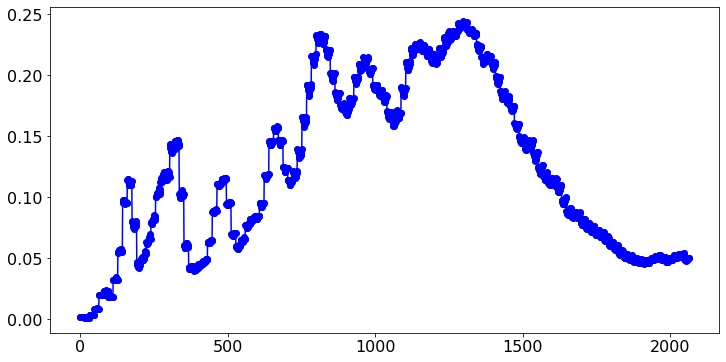

In [136]:
plt.figure(figsize=(12,6))
plt.plot(pca_model.mean_,'-ob')

In [137]:
pca_model.n_components_

834

#### reconstruction with a lower dimensional PCA model

In [18]:
from copy import deepcopy

In [150]:
pca_short = deepcopy(pca_model)

In [151]:
pca_short.components_ = pca_short.components_[:64,:]

In [152]:
Xhat_low_pca, _ = reconstruction(X, pca_short)

.... done with 0.0 percent ....
.... done with 0.017205781142463867 percent ....
.... done with 0.034411562284927734 percent ....
.... done with 0.051617343427391604 percent ....
.... done with 0.06882312456985547 percent ....
.... done with 0.08602890571231935 percent ....
.... done with 0.10323468685478321 percent ....
.... done with 0.12044046799724707 percent ....
.... done with 0.13764624913971094 percent ....
.... done with 0.1548520302821748 percent ....
.... done with 0.1720578114246387 percent ....
.... done with 0.18926359256710254 percent ....
.... done with 0.20646937370956642 percent ....
.... done with 0.2236751548520303 percent ....
.... done with 0.24088093599449414 percent ....
.... done with 0.258086717136958 percent ....
.... done with 0.27529249827942187 percent ....
.... done with 0.2924982794218858 percent ....
.... done with 0.3097040605643496 percent ....
.... done with 0.3269098417068135 percent ....
.... done with 0.3441156228492774 percent ....
.... done with

### Vectorize the spectrograms for MSE computation

In [131]:
def make_vectors(Y):
    Yout = []
    for seq in Y:
        ychunks = split_song_sequence(seq, 16)
        ychunks = np.concatenate([y.flatten().reshape(1,-1) for y in ychunks])
        Yout.append(ychunks)
    return np.concatenate(Yout)

In [132]:
Xorig = make_vectors(X)
Xorig.shape

(61557, 2064)

In [141]:
Xhat_vec = make_vectors(Xhat)
Xhat_vec.shape

(61557, 2064)

In [142]:
Xhat_pca_vec = make_vectors(Xhat_pca)
Xhat_pca_vec.shape

(61557, 2064)

In [143]:
Xhat_low_pca_vec = make_vectors(Xhat_low_pca)
Xhat_low_pca_vec.shape

(61557, 2064)

### Compute L2 norm and L2 norm for NN and PCA

In [173]:
L2_gan = ((Xorig - Xhat_vec)**2).sum(axis=1).mean()
L2_pca = ((Xorig - Xhat_pca_vec)**2).sum(axis=1).mean()
L2_low_pca = ((Xorig - Xhat_low_pca_vec)**2).sum(axis=1).mean()

In [174]:
print(L2_gan, L2_pca, L2_low_pca)

40.63719280444051 1.8407970260426212 33.509481956931175


In [175]:
L1_gan = (np.abs(Xorig - Xhat_vec)).sum(axis=1).mean()
L1_pca = (np.abs(Xorig - Xhat_pca_vec)).sum(axis=1).mean()
L1_low_pca = (np.abs(Xorig - Xhat_low_pca_vec)).sum(axis=1).mean()

In [176]:
print(L1_gan, L1_pca, L1_low_pca)

138.02871906811242 35.45403400654042 145.21287252456537


# Plot reconstructions

In [30]:
from utils.utils import rescale_spectrogram

In [168]:
N = 30

Text(0, 0.5, '64 dim PCA')

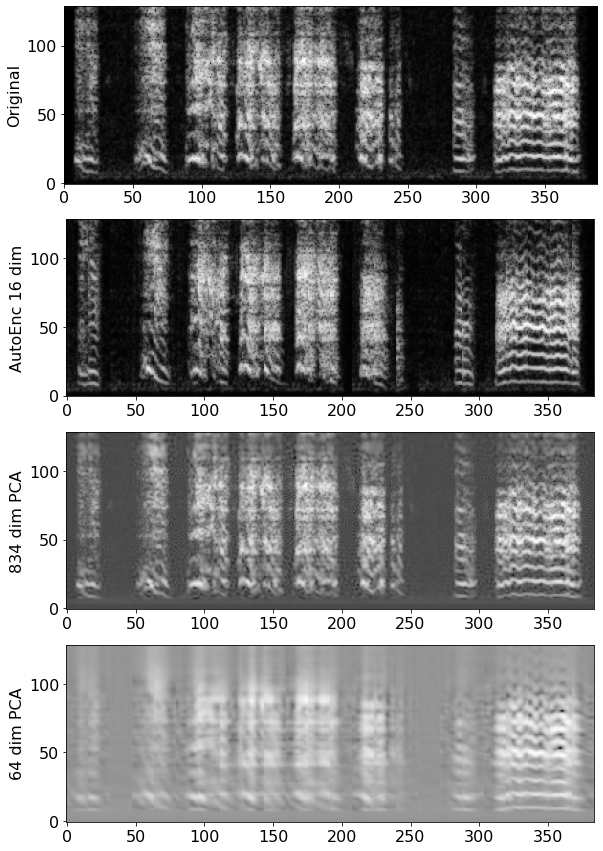

In [172]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(22,15))

# original
ax[0].imshow(rescale_spectrogram(X[N]), origin='lower', cmap='gray')
ax[0].set_ylabel('Original')

ax[1].imshow(rescale_spectrogram(Xhat[N]), origin='lower', cmap='gray')
ax[1].set_ylabel('AutoEnc 16 dim')

ax[2].imshow(rescale_spectrogram(Xhat_pca[N]), origin='lower', cmap='gray')
ax[2].set_ylabel(f'{pca_model.n_components_} dim PCA')

ax[3].imshow(rescale_spectrogram(Xhat_low_pca[N]), origin='lower', cmap='gray')
ax[3].set_ylabel('64 dim PCA')

#plt.savefig('/home/songbird/Dropbox/Work/MDGAN_paper/Figures_for_paper/Final_figures/Figure1/AE_vs_PCA_r15y5_nz16_day18_3.png', dpi=100,
#           format='png')
#plt.close()

In [123]:
def split_song_sequence(x, chunk_len = 16):
    X = []
    nchunks = x.shape[-1] // chunk_len
    idx = 0
    for n in range(nchunks):
        X.append(x[:,idx : idx + chunk_len])
        idx += chunk_len
    return X

In [130]:
def reconstruction(X, model = None, n_components = 0.97, random_state = 0, 
                  chunk_len = 16, imageH = 129):
    """For a list of spectrograms, make reconstruction
        Params
        ------
            X :  either a single spectrogram (numpy.ndarray) or a list of 
                spectrograms, or a list of spectrogram chunks]
            model : sklearn.decomposition.PCA model object. If None, learns
                    one
            n_components : int or float, if int, it is the exact number of 
                        principal components extracted
        Returns
        -------
            Xhat : list of spectrogram reconstructions
            model : PCA model
            
    """ 
    
    if type(X)==np.ndarray:
        # this is a single spectrogram, so split it 
        X = split_song_sequence(X, chunk_len)
    elif type(X) == list and X[0].shape[-1] > chunk_len:
        # this is a list of song spectrograms
        # -> list of list of chunks
        X = [split_song_sequence(x, chunk_len) for x in X]
        
    if model is None:
        model = learn_pca_model(X, n_components, random_state)
        
    # reconstruct
    Xhat = []
    for i in range(len(X)):
        if type(X[i]) == list:
            recon = []
            for k in range(len(X[i])):
                xhat = pca_decode(pca_encode(X[i][k], model), 
                                 model, imageH, chunk_len)
                recon.append(xhat)
            # reconstruct a single song
            recon = np.concatenate(recon,axis=-1)
            Xhat.append(recon)
            
            if i%50 == 0:
                print(f'.... done with {i/len(X)} percent ....')
        else:
            xhat = pca_decode(pca_encode(X[i][k], model))
            Xhat.append(xhat)
            
    return Xhat, model

In [125]:
Xhat_low_pca[0].shape

(129, 128)

In [156]:
help(np.tile)

Help on function tile in module numpy:

tile(A, reps)
    Construct an array by repeating A the number of times given by reps.
    
    If `reps` has length ``d``, the result will have dimension of
    ``max(d, A.ndim)``.
    
    If ``A.ndim < d``, `A` is promoted to be d-dimensional by prepending new
    axes. So a shape (3,) array is promoted to (1, 3) for 2-D replication,
    or shape (1, 1, 3) for 3-D replication. If this is not the desired
    behavior, promote `A` to d-dimensions manually before calling this
    function.
    
    If ``A.ndim > d``, `reps` is promoted to `A`.ndim by pre-pending 1's to it.
    Thus for an `A` of shape (2, 3, 4, 5), a `reps` of (2, 2) is treated as
    (1, 1, 2, 2).
    
    Note : Although tile may be used for broadcasting, it is strongly
    recommended to use numpy's broadcasting operations and functions.
    
    Parameters
    ----------
    A : array_like
        The input array.
    reps : array_like
        The number of repetitions of `A`